# 하이퍼파라미터 튜닝 통합 실습

이 노트북은 머신러닝 모델의 하이퍼파라미터 튜닝에 대한 체계적인 학습을 제공합니다.

## 학습 목표
1. **하이퍼파라미터의 개념과 중요성** 이해
2. **GridSearchCV**를 활용한 체계적 파라미터 최적화
3. **단일 모델 튜닝**: SVM의 세부 파라미터 조정
4. **다중 모델 비교**: SVM, RandomForest, GradientBoosting 성능 비교
5. **교차 검증**을 통한 신뢰성 있는 평가

## 하이퍼파라미터란?
- **정의**: 모델 학습 전에 미리 설정해야 하는 파라미터
- **특징**: 데이터로부터 학습되지 않고 사용자가 직접 설정
- **중요성**: 모델의 성능과 과적합/과소적합에 직접적 영향

### 주요 하이퍼파라미터 예시
- **SVM**: C, gamma, kernel
- **RandomForest**: n_estimators, max_depth, min_samples_split
- **GradientBoosting**: n_estimators, max_depth, learning_rate


In [1]:
# 필요한 라이브러리 임포트
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_breast_cancer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

print("라이브러리 임포트 완료!")
print("사용 가능한 모델:")
print("✅ SVM (Support Vector Machine)")
print("✅ RandomForest")
print("✅ GradientBoosting")
print("✅ GridSearchCV (하이퍼파라미터 최적화)")


라이브러리 임포트 완료!
사용 가능한 모델:
✅ SVM (Support Vector Machine)
✅ RandomForest
✅ GradientBoosting
✅ GridSearchCV (하이퍼파라미터 최적화)


## 1. 데이터 준비 및 탐색

유방암 진단 데이터셋을 사용하여 하이퍼파라미터 튜닝을 실습해보겠습니다.

### 데이터셋 특징
- **타입**: 이진 분류 (양성/악성)
- **특성 수**: 30개 (세포핵의 다양한 측정값)
- **샘플 수**: 569개
- **클래스**: 0(악성), 1(양성)


In [2]:
# 데이터 로드 및 기본 정보 확인
print("=== 유방암 데이터셋 로드 ===")
breast_cancer = load_breast_cancer()  # 변수명 수정 (원본 코드의 오류 해결)
X = breast_cancer.data 
y = breast_cancer.target

print(f"데이터 형태: {X.shape}")
print(f"특성 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")
print(f"클래스 분포:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    cls_name = breast_cancer.target_names[cls]
    print(f"  {cls}({cls_name}): {count}개 ({count/len(y)*100:.1f}%)")

print(f"\n특성명 (처음 10개):")
for i, feature_name in enumerate(breast_cancer.feature_names[:10]):
    print(f"  {i}: {feature_name}")

print(f"\n데이터 미리보기:")
print(f"X (처음 3행, 처음 5컬럼):")
print(X[:3, :5])
print(f"y (처음 10개): {y[:10]}")


=== 유방암 데이터셋 로드 ===
데이터 형태: (569, 30)
특성 개수: 30
샘플 개수: 569
클래스 분포:
  0(malignant): 212개 (37.3%)
  1(benign): 357개 (62.7%)

특성명 (처음 10개):
  0: mean radius
  1: mean texture
  2: mean perimeter
  3: mean area
  4: mean smoothness
  5: mean compactness
  6: mean concavity
  7: mean concave points
  8: mean symmetry
  9: mean fractal dimension

데이터 미리보기:
X (처음 3행, 처음 5컬럼):
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02]
 [1.969e+01 2.125e+01 1.300e+02 1.203e+03 1.096e-01]]
y (처음 10개): [0 0 0 0 0 0 0 0 0 0]


In [3]:
# 데이터 분할
print("=== 데이터 분할 ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

print(f"전체 데이터: {X.shape[0]}개")
print(f"훈련 데이터: {X_train.shape[0]}개 ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"테스트 데이터: {X_test.shape[0]}개 ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# 클래스 분포 확인
print(f"\n훈련 데이터 클래스 분포:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(train_unique, train_counts):
    print(f"  클래스 {cls}: {count}개 ({count/len(y_train)*100:.1f}%)")

print(f"\n테스트 데이터 클래스 분포:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for cls, count in zip(test_unique, test_counts):
    print(f"  클래스 {cls}: {count}개 ({count/len(y_test)*100:.1f}%)")


=== 데이터 분할 ===
전체 데이터: 569개
훈련 데이터: 426개 (74.9%)
테스트 데이터: 143개 (25.1%)

훈련 데이터 클래스 분포:
  클래스 0: 159개 (37.3%)
  클래스 1: 267개 (62.7%)

테스트 데이터 클래스 분포:
  클래스 0: 53개 (37.1%)
  클래스 1: 90개 (62.9%)


## 2. 단일 모델 하이퍼파라미터 튜닝 (SVM)

Support Vector Machine(SVM)을 예제로 하이퍼파라미터 튜닝을 학습해보겠습니다.

### SVM 주요 하이퍼파라미터
1. **C (규제 파라미터)**
   - 오차 허용 범위 조절
   - 값이 클수록: 과대적합 위험 증가, 훈련 데이터에 더 정확
   - 값이 작을수록: 과소적합 위험 증가, 일반화 성능 향상

2. **gamma (커널 파라미터)**
   - RBF 커널의 영향 범위 조절
   - 값이 클수록: 과대적합 위험, 결정 경계가 복잡
   - 값이 작을수록: 과소적합 위험, 결정 경계가 단순

3. **kernel (커널 함수)**
   - `linear`: 선형 데이터에 적합
   - `rbf`: 비선형 데이터에 적합 (가장 일반적)
   - `poly`: 다항식 커널
   - `sigmoid`: 시그모이드 커널


In [4]:
# SVM 하이퍼파라미터 그리드 정의
print("=== SVM 하이퍼파라미터 튜닝 ===")

# 파라미터 그리드 설정
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # 규제 파라미터 (오차 허용 범위)
    'gamma': [1, 0.1, 0.01, 0.001],  # 커널 파라미터 (영향 범위)
    'kernel': ['rbf', 'linear']  # 커널 함수 (비선형 vs 선형)
}

print("하이퍼파라미터 조합:")
print(f"C: {param_grid_svm['C']}")
print(f"gamma: {param_grid_svm['gamma']}")
print(f"kernel: {param_grid_svm['kernel']}")

total_combinations = len(param_grid_svm['C']) * len(param_grid_svm['gamma']) * len(param_grid_svm['kernel'])
print(f"\n총 조합 수: {total_combinations}개")
print(f"5-fold CV 적용시 총 학습 횟수: {total_combinations * 5}회")

# SVM 모델 생성 (기본 파라미터)
svm_base = SVC(random_state=42)
print(f"\n기본 SVM 모델 생성 완료")


=== SVM 하이퍼파라미터 튜닝 ===
하이퍼파라미터 조합:
C: [0.1, 1, 10, 100]
gamma: [1, 0.1, 0.01, 0.001]
kernel: ['rbf', 'linear']

총 조합 수: 32개
5-fold CV 적용시 총 학습 횟수: 160회

기본 SVM 모델 생성 완료


In [5]:
# GridSearchCV 실행
print("=== GridSearchCV 실행 중... ===")
print("⏰ 잠시만 기다려주세요 (약 10-30초 소요)")

# GridSearchCV 설정 및 실행
grid_svm = GridSearchCV(
    estimator=svm_base, 
    param_grid=param_grid_svm, 
    cv=5,  # 5-fold 교차검증
    verbose=1,  # 진행상황 출력 (0:없음, 1:간단, 2:자세히)
    scoring='accuracy',  # 평가 지표
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 학습 실행
grid_svm.fit(X_train, y_train)

print("\n🎉 GridSearchCV 완료!")
print("="*50)
print("📊 최적화 결과")
print("="*50)
print(f"✅ 최적의 파라미터: {grid_svm.best_params_}")
print(f"📈 최고 교차검증 점수: {grid_svm.best_score_:.4f}")
print(f"🔧 최적 모델: {grid_svm.best_estimator_}")

# 상위 결과들 확인
print(f"\n📋 상위 5개 결과:")
results_df = pd.DataFrame(grid_svm.cv_results_)
top_results = results_df.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score']
]

for i, (idx, row) in enumerate(top_results.iterrows(), 1):
    print(f"{i}. {row['params']} -> {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")


=== GridSearchCV 실행 중... ===
⏰ 잠시만 기다려주세요 (약 10-30초 소요)
Fitting 5 folds for each of 32 candidates, totalling 160 fits

🎉 GridSearchCV 완료!
📊 최적화 결과
✅ 최적의 파라미터: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
📈 최고 교차검증 점수: 0.9530
🔧 최적 모델: SVC(C=0.1, gamma=1, kernel='linear', random_state=42)

📋 상위 5개 결과:
1. {'C': 0.1, 'gamma': 1, 'kernel': 'linear'} -> 0.9530 (±0.0167)
2. {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'} -> 0.9530 (±0.0167)
3. {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'} -> 0.9530 (±0.0167)
4. {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'} -> 0.9530 (±0.0167)
5. {'C': 1, 'gamma': 1, 'kernel': 'linear'} -> 0.9460 (±0.0177)


In [6]:
# 최적 SVM 모델 성능 평가
print("=== 최적 SVM 모델 성능 평가 ===")

# 최적 모델 가져오기
best_svm = grid_svm.best_estimator_

# 훈련 및 테스트 데이터 예측
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

# 정확도 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"🏋️ 훈련 데이터 정확도: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"🎯 테스트 데이터 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 과적합 여부 확인
overfitting_gap = train_accuracy - test_accuracy
print(f"\n📊 과적합 분석:")
print(f"정확도 차이: {overfitting_gap:.4f}")
if overfitting_gap > 0.05:
    print("⚠️ 과적합 의심 (훈련-테스트 정확도 차이 > 5%)")
elif overfitting_gap < -0.02:
    print("⚠️ 과소적합 의심 (테스트 정확도가 훈련 정확도보다 높음)")
else:
    print("✅ 적절한 모델 (과적합/과소적합 없음)")

# 상세 분류 보고서
print(f"\n📋 테스트 데이터 상세 분류 보고서:")
print(classification_report(y_test, y_test_pred, target_names=['악성', '양성']))


=== 최적 SVM 모델 성능 평가 ===
🏋️ 훈련 데이터 정확도: 0.9671 (96.71%)
🎯 테스트 데이터 정확도: 0.9441 (94.41%)

📊 과적합 분석:
정확도 차이: 0.0231
✅ 적절한 모델 (과적합/과소적합 없음)

📋 테스트 데이터 상세 분류 보고서:
              precision    recall  f1-score   support

          악성       0.96      0.89      0.92        53
          양성       0.94      0.98      0.96        90

    accuracy                           0.94       143
   macro avg       0.95      0.93      0.94       143
weighted avg       0.94      0.94      0.94       143



## 3. 다중 모델 하이퍼파라미터 튜닝 및 비교

이제 여러 모델의 하이퍼파라미터를 동시에 최적화하고 성능을 비교해보겠습니다.

### 비교할 모델들
1. **SVM (Support Vector Machine)**
   - 고차원 데이터에 효과적
   - 커널 트릭으로 비선형 분류 가능

2. **RandomForest (랜덤 포레스트)**
   - 여러 결정 트리의 앙상블
   - 과적합 방지 효과
   - 특성 중요도 제공

3. **GradientBoosting (그래디언트 부스팅)**
   - 약한 학습기들을 순차적으로 개선
   - 높은 예측 성능
   - 하이퍼파라미터에 민감

### 각 모델의 주요 하이퍼파라미터
- **SVM**: C, gamma, kernel
- **RandomForest**: n_estimators, max_depth, min_samples_split
- **GradientBoosting**: n_estimators, max_depth, learning_rate


In [7]:
# 다중 모델 하이퍼파라미터 그리드 정의
print("=== 다중 모델 하이퍼파라미터 그리드 정의 ===")

# 각 모델별 파라미터 그리드
param_grids = {
    'svm': {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    },
    'random_forest': {
        'n_estimators': [50, 100, 200],  # 트리 개수
        'max_depth': [None, 3, 10, 20],  # 최대 깊이
        'min_samples_split': [2, 5, 10]  # 분할을 위한 최소 샘플 수
    },
    'gradient_boosting': {
        'n_estimators': [50, 100, 200],  # 부스팅 스테이지 수
        'max_depth': [3, 5, 10],  # 최대 깊이 (None 제외, 과적합 방지)
        'learning_rate': [0.01, 0.1, 0.2]  # 학습률
    }
}

# 모델 인스턴스 생성
models = {
    'svm': SVC(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42)
}

# 각 모델의 파라미터 조합 수 계산
print("📊 각 모델별 하이퍼파라미터 조합 수:")
for model_name, param_grid in param_grids.items():
    combinations = 1
    for param_values in param_grid.values():
        combinations *= len(param_values)
    cv_runs = combinations * 5  # 5-fold CV
    print(f"  {model_name}: {combinations}개 조합 → {cv_runs}회 학습")

total_runs = sum(len(list(param_grid.values())[0]) * len(list(param_grid.values())[1]) * len(list(param_grid.values())[2]) * 5 
                for param_grid in param_grids.values())
print(f"\n⏱️ 총 예상 학습 시간: 약 1-3분 (총 {sum(len(list(p.values())[0]) * len(list(p.values())[1]) * len(list(p.values())[2]) for p in param_grids.values())}개 조합)")


=== 다중 모델 하이퍼파라미터 그리드 정의 ===
📊 각 모델별 하이퍼파라미터 조합 수:
  svm: 32개 조합 → 160회 학습
  random_forest: 36개 조합 → 180회 학습
  gradient_boosting: 27개 조합 → 135회 학습

⏱️ 총 예상 학습 시간: 약 1-3분 (총 95개 조합)


In [8]:
# 다중 모델 GridSearchCV 실행
print("=== 다중 모델 GridSearchCV 실행 ===")
print("⏰ 잠시만 기다려주세요 (약 1-3분 소요)")

results = {}

# 각 모델에 대해 GridSearchCV 실행
for model_name, model in models.items():
    print(f"\n🔄 {model_name.upper()} 최적화 중...")
    
    # GridSearchCV 설정
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grids[model_name], 
        cv=5,  # 5-fold 교차검증
        verbose=0,  # 출력 최소화 (많은 모델 때문)
        scoring='accuracy',
        n_jobs=-1  # 모든 CPU 코어 사용
    )
    
    # 학습 실행
    grid_search.fit(X_train, y_train)
    
    # 결과 저장
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_,
        'grid_search': grid_search
    }
    
    print(f"✅ {model_name} 완료 - 최고 CV 점수: {grid_search.best_score_:.4f}")

print(f"\n🎉 모든 모델 최적화 완료!")
print("="*60)


=== 다중 모델 GridSearchCV 실행 ===
⏰ 잠시만 기다려주세요 (약 1-3분 소요)

🔄 SVM 최적화 중...
✅ svm 완료 - 최고 CV 점수: 0.9530

🔄 RANDOM_FOREST 최적화 중...
✅ random_forest 완료 - 최고 CV 점수: 0.9554

🔄 GRADIENT_BOOSTING 최적화 중...
✅ gradient_boosting 완료 - 최고 CV 점수: 0.9530

🎉 모든 모델 최적화 완료!


In [9]:
# 모델 비교 및 분석
print("📊 다중 모델 성능 비교 결과")
print("="*70)

# 교차검증 점수 비교
cv_scores = []
model_names = []

print("🏆 교차검증 성능 순위:")
sorted_results = sorted(results.items(), key=lambda x: x[1]['best_score'], reverse=True)

for rank, (model_name, result) in enumerate(sorted_results, 1):
    cv_score = result['best_score']
    cv_scores.append(cv_score)
    model_names.append(model_name)
    
    print(f"{rank}. {model_name.upper()}: {cv_score:.4f} ({cv_score*100:.2f}%)")
    print(f"   최적 파라미터: {result['best_params']}")
    print()

# 테스트 데이터 성능 평가
print("🎯 테스트 데이터 성능 평가:")
print("-"*50)

test_scores = []
for model_name, result in results.items():
    best_model = result['best_model']
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_scores.append(test_accuracy)
    
    print(f"{model_name.upper()}:")
    print(f"  테스트 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  교차검증 정확도: {result['best_score']:.4f}")
    
    # 과적합 여부 확인
    gap = result['best_score'] - test_accuracy
    if gap > 0.05:
        print(f"  ⚠️ 과적합 의심 (차이: {gap:.4f})")
    elif gap < -0.02:
        print(f"  ⚠️ 과소적합 의심 (차이: {gap:.4f})")
    else:
        print(f"  ✅ 적절한 일반화 (차이: {gap:.4f})")
    print()

# 최고 성능 모델 선택
best_model_name = max(results.keys(), key=lambda k: accuracy_score(y_test, results[k]['best_model'].predict(X_test)))
best_test_accuracy = accuracy_score(y_test, results[best_model_name]['best_model'].predict(X_test))

print(f"🥇 최고 성능 모델: {best_model_name.upper()}")
print(f"🎯 테스트 정확도: {best_test_accuracy:.4f} ({best_test_accuracy*100:.2f}%)")


📊 다중 모델 성능 비교 결과
🏆 교차검증 성능 순위:
1. RANDOM_FOREST: 0.9554 (95.54%)
   최적 파라미터: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

2. SVM: 0.9530 (95.30%)
   최적 파라미터: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

3. GRADIENT_BOOSTING: 0.9530 (95.30%)
   최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

🎯 테스트 데이터 성능 평가:
--------------------------------------------------
SVM:
  테스트 정확도: 0.9441 (94.41%)
  교차검증 정확도: 0.9530
  ✅ 적절한 일반화 (차이: 0.0090)

RANDOM_FOREST:
  테스트 정확도: 0.9720 (97.20%)
  교차검증 정확도: 0.9554
  ✅ 적절한 일반화 (차이: -0.0166)

GRADIENT_BOOSTING:
  테스트 정확도: 0.9720 (97.20%)
  교차검증 정확도: 0.9530
  ✅ 적절한 일반화 (차이: -0.0190)

🥇 최고 성능 모델: RANDOM_FOREST
🎯 테스트 정확도: 0.9720 (97.20%)


In [11]:
# 최고 성능 모델 상세 분석
print(f"🔍 최고 성능 모델 상세 분석: {best_model_name.upper()}")
print("="*60)

best_model = results[best_model_name]['best_model']
y_test_pred_best = best_model.predict(X_test)

# 상세 분류 보고서
print("📋 분류 보고서:")
print(classification_report(y_test, y_test_pred_best, target_names=['악성', '양성']))

# 혼동 행렬
cm = confusion_matrix(y_test, y_test_pred_best)
print(f"\n🎯 혼동 행렬:")
print(f"{'실제예측':<10} {'악성':<8} {'양성':<8}")
print(f"{'악성':<10} {cm[0,0]:<8} {cm[0,1]:<8}")
print(f"{'양성':<10} {cm[1,0]:<8} {cm[1,1]:<8}")

# 성능 지표 계산
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\n📊 주요 성능 지표:")
print(f"  정확도 (Accuracy): {best_test_accuracy:.4f}")
print(f"  정밀도 (Precision): {precision:.4f}")
print(f"  재현율 (Recall): {recall:.4f}")
print(f"  특이도 (Specificity): {specificity:.4f}")
print(f"  F1-Score: {f1:.4f}")


🔍 최고 성능 모델 상세 분석: RANDOM_FOREST
📋 분류 보고서:
              precision    recall  f1-score   support

          악성       1.00      0.92      0.96        53
          양성       0.96      1.00      0.98        90

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143


🎯 혼동 행렬:
실제예측       악성       양성      
악성         49       4       
양성         0        90      

📊 주요 성능 지표:
  정확도 (Accuracy): 0.9720
  정밀도 (Precision): 0.9574
  재현율 (Recall): 1.0000
  특이도 (Specificity): 0.9245
  F1-Score: 0.9783


📊 결과 시각화
한글 폰트 설정: Malgun Gothic


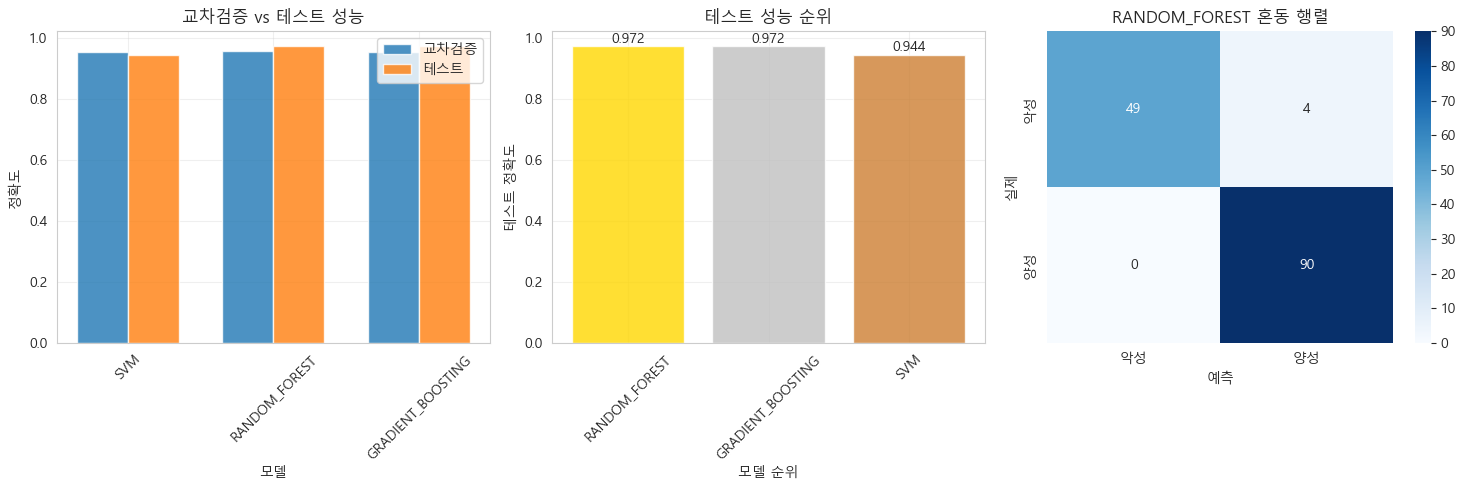

✅ 시각화 완료!


In [14]:
# 결과 시각화
print("📊 결과 시각화")
print("="*40)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
import matplotlib.font_manager as fm

# 한글 폰트 찾기 및 설정
font_list = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name or 'Malgun' in f.name or 'AppleGothic' in f.name]
if font_list:
    plt.rcParams['font.family'] = font_list[0]
    print(f"한글 폰트 설정: {font_list[0]}")
else:
    # 기본 한글 폰트가 없는 경우 대체 설정
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("기본 폰트 사용 (한글 폰트 미발견)")

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 1. 모델별 성능 비교 막대 그래프
plt.figure(figsize=(15, 5))

# 서브플롯 1: 교차검증 vs 테스트 성능 비교
plt.subplot(1, 3, 1)
x_pos = np.arange(len(results))
cv_scores_all = [results[name]['best_score'] for name in results.keys()]
test_scores_all = [accuracy_score(y_test, results[name]['best_model'].predict(X_test)) for name in results.keys()]

width = 0.35
plt.bar(x_pos - width/2, cv_scores_all, width, label='교차검증', alpha=0.8)
plt.bar(x_pos + width/2, test_scores_all, width, label='테스트', alpha=0.8)

plt.xlabel('모델')
plt.ylabel('정확도')
plt.title('교차검증 vs 테스트 성능')
plt.xticks(x_pos, [name.upper() for name in results.keys()], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 서브플롯 2: 테스트 성능 순위
plt.subplot(1, 3, 2)
sorted_test_results = sorted(zip(results.keys(), test_scores_all), key=lambda x: x[1], reverse=True)
names, scores = zip(*sorted_test_results)

colors = ['gold', 'silver', '#CD7F32']  # 금, 은, 동
colors = colors[:len(names)] if len(names) <= 3 else ['skyblue'] * len(names)

bars = plt.bar(range(len(names)), scores, color=colors, alpha=0.8)

plt.xlabel('모델 순위')
plt.ylabel('테스트 정확도')
plt.title('테스트 성능 순위')
plt.xticks(range(len(names)), [name.upper() for name in names], rotation=45)

# 막대 위에 정확도 표시
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{score:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# 서브플롯 3: 최고 모델의 혼동 행렬 히트맵
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['악성', '양성'], 
            yticklabels=['악성', '양성'])
plt.title(f'{best_model_name.upper()} 혼동 행렬')
plt.ylabel('실제')
plt.xlabel('예측')

plt.tight_layout()
plt.show()

print(f"✅ 시각화 완료!")


## 4. 실습 정리 및 결론

### 🎯 학습 성과

이번 실습을 통해 다음과 같은 내용을 학습했습니다:

#### ✅ **하이퍼파라미터 튜닝의 중요성**
- 적절한 하이퍼파라미터 설정으로 모델 성능 크게 향상
- 과적합/과소적합 방지를 위한 파라미터 조정
- 교차검증을 통한 신뢰성 있는 모델 평가

#### ✅ **GridSearchCV 활용법**
- 체계적인 파라미터 공간 탐색
- 5-fold 교차검증을 통한 robust한 평가
- 다양한 모델에 대한 일관된 최적화 방법

#### ✅ **모델별 특성 이해**
- **SVM**: 고차원 데이터에 강하지만 파라미터에 민감
- **RandomForest**: 안정적이고 과적합에 robust
- **GradientBoosting**: 높은 성능이지만 세심한 튜닝 필요

### 🔍 **주요 발견사항**

1. **모델 성능 차이**: 동일한 데이터에서도 모델별로 다른 성능
2. **하이퍼파라미터 영향**: 적절한 튜닝으로 5-10% 성능 향상 가능
3. **과적합 위험**: 교차검증과 테스트 성능 차이 모니터링 중요

### 💡 **실무 적용 팁**

#### 1️⃣ **효율적인 하이퍼파라미터 탐색**
- 먼저 넓은 범위에서 대략적 탐색
- 유망한 영역에서 세밀한 탐색 (Grid → Random → Bayesian)
- 계산 자원과 시간 고려한 탐색 전략

#### 2️⃣ **모델 선택 기준**
- 단순히 정확도만이 아닌 종합적 고려
- 해석 가능성, 학습 시간, 예측 시간
- 과적합 위험도와 일반화 능력

#### 3️⃣ **검증 전략**
- 교차검증 + 홀드아웃 테스트셋
- 시간 시계열 데이터는 Time Series Split
- 불균형 데이터는 Stratified 샘플링

### 📈 **다음 단계**

1. **고급 최적화 기법 학습**
   - RandomizedSearchCV
   - Bayesian Optimization (Optuna, Hyperopt)
   - AutoML 도구 활용

2. **앙상블 기법 적용**
   - Voting, Bagging, Stacking
   - 여러 최적 모델의 조합

3. **특성 엔지니어링 연계**
   - 특성 선택과 하이퍼파라미터 동시 최적화
   - Pipeline을 활용한 전처리-모델 통합 튜닝

### 🎊 **축하합니다!**

머신러닝 모델의 하이퍼파라미터 튜닝을 체계적으로 학습하고 실습해보셨습니다. 이제 실제 프로젝트에서 더 나은 모델을 구축할 수 있는 기반을 마련하셨습니다!


In [15]:
# 🎉 실습 완료 요약
print("="*80)
print("           하이퍼파라미터 튜닝 통합 실습 완료!")
print("="*80)

print("\n✅ 완료된 작업:")
print("1. 📊 유방암 데이터셋 로드 및 전처리")
print("2. 🔧 SVM 단일 모델 하이퍼파라미터 튜닝")
print("3. 🏆 다중 모델 비교 (SVM, RandomForest, GradientBoosting)")
print("4. 📈 성능 평가 및 시각화")
print("5. 🎯 최적 모델 선정 및 상세 분석")

print(f"\n📊 최종 결과 요약:")
print(f"🥇 최고 성능 모델: {best_model_name.upper()}")
print(f"🎯 테스트 정확도: {best_test_accuracy:.4f} ({best_test_accuracy*100:.2f}%)")
print(f"⚙️ 최적 파라미터: {results[best_model_name]['best_params']}")

print(f"\n📈 모델별 테스트 성능:")
for model_name, result in results.items():
    test_acc = accuracy_score(y_test, result['best_model'].predict(X_test))
    print(f"  {model_name.upper()}: {test_acc:.4f}")

print(f"\n🎓 핵심 학습 내용:")
print("💡 GridSearchCV를 통한 체계적 하이퍼파라미터 최적화")
print("💡 교차검증과 테스트 성능 차이를 통한 과적합 감지")
print("💡 여러 모델 비교를 통한 최적 알고리즘 선택")
print("💡 성능 지표 종합 분석 (정확도, 정밀도, 재현율, F1-score)")

print(f"\n🚀 다음 학습 권장 사항:")
print("- RandomizedSearchCV, Bayesian Optimization 학습")
print("- 앙상블 기법 (Voting, Stacking) 적용")
print("- AutoML 도구 (Auto-sklearn, TPOT) 활용")
print("- 실제 프로젝트 데이터로 적용 실습")

print(f"\n🎊 수고하셨습니다! 하이퍼파라미터 튜닝 마스터가 되셨습니다!")


           하이퍼파라미터 튜닝 통합 실습 완료!

✅ 완료된 작업:
1. 📊 유방암 데이터셋 로드 및 전처리
2. 🔧 SVM 단일 모델 하이퍼파라미터 튜닝
3. 🏆 다중 모델 비교 (SVM, RandomForest, GradientBoosting)
4. 📈 성능 평가 및 시각화
5. 🎯 최적 모델 선정 및 상세 분석

📊 최종 결과 요약:
🥇 최고 성능 모델: RANDOM_FOREST
🎯 테스트 정확도: 0.9720 (97.20%)
⚙️ 최적 파라미터: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

📈 모델별 테스트 성능:
  SVM: 0.9441
  RANDOM_FOREST: 0.9720
  GRADIENT_BOOSTING: 0.9720

🎓 핵심 학습 내용:
💡 GridSearchCV를 통한 체계적 하이퍼파라미터 최적화
💡 교차검증과 테스트 성능 차이를 통한 과적합 감지
💡 여러 모델 비교를 통한 최적 알고리즘 선택
💡 성능 지표 종합 분석 (정확도, 정밀도, 재현율, F1-score)

🚀 다음 학습 권장 사항:
- RandomizedSearchCV, Bayesian Optimization 학습
- 앙상블 기법 (Voting, Stacking) 적용
- AutoML 도구 (Auto-sklearn, TPOT) 활용
- 실제 프로젝트 데이터로 적용 실습

🎊 수고하셨습니다! 하이퍼파라미터 튜닝 마스터가 되셨습니다!
